# 元细胞聚合

极其大型（超过 500 ~ 1000 万细胞）的数据集对于计算资源的要求是没有止境的。注意到大型数据集经常会将同样表型的细胞多次捕获，我们可以
通过一些方法去除表型上的冗余。元细胞聚合方法是去除冗余的算法之一，其将表型近似的细胞平均成一个细胞（一般是对数表达量的均值），表型密度
更大处，一个聚合中所含的原始细胞可能更多，从而缓解冗余并调整样本分布。（注意，如果这个算法每个元细胞中平均的原始细胞数不同，细胞
计数分布情况可能会改变，而影响细胞比例的结果）。其带来的后果是更少的细胞量和更加稠密的表达矩阵

一般认为对数表达量矩阵是可加的，因为它已经被标准化了，而原始计数矩阵不一定可加。考虑到不同测序计数的基因分布族可能不是共享参数的。
而归一化矩阵则是绝对不可加的。我们一般输出对数表达量矩阵作为元细胞唯一可靠的状态空间

一旦细胞被按照相似性整合，想要还原其批次信息和其他元数据是非常困难和不准确的。因此，如果你的样本存在批次效应并希望运行整合算法，你应该
先对每个样本分别运行元细胞方法，再将聚合后的细胞对数表达量按照批次整合。Harmony，和其他基于 kNN 的方法天然的支持对数表达量的矩阵，
而 scVI 是基于原始计数数据，其声称对于标准化的虚拟计数也具有一定的稳定性

In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import exprmat as em
em.setwd('/home/data/yangz/bioinfo/geo/m-bone-marrow-metastasis')
ver = em.version()

[i] exprmat 0.1.45 / exprmat-db 0.1.45
[i] os: posix (linux)  platform version: 5.15.0-139-generic
[i] loaded configuration from /home/data/yangz/.exprmatrc
[i] current working directory: /home/data/yangz/bioinfo/geo/m-bone-marrow-metastasis
[i] current database directory: /home/data/yangz/bioinfo/packages/database (0.1.45)
[i] resident memory: 799.77 MiB
[i] virtual memory: 5.71 GiB


In [3]:
expm = em.load_experiment('expm', load_samples = False)

[!] samples are not dumped in the experiment directory.


In [4]:
print(expm)

annotated data of size 14626 × 20349
integrated dataset of size 14626 × 20349
contains modalities: rna

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f64> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
          leiden <cat> ppt.pseudotime <f64> ppt.seg <cat> ppt.edge <cat> ppt.milestones <cat>
    var : chr <cat> start <i64> end <i64> strand <cat> id <o> subtype <cat> gene <cat> tlen <f64>
          cdslen <i64> assembly <cat> uid <o> vst.hvg <bool> vst.all.means <f64> vst.all.vars <f64>
          vst.all.vars.norm <f64> vst.all.hvg.rank <f32> vst.all.hvg <bool>
 layers : counts <f32> magic <f64>
   obsm : harmony <arr:f64(50)> knn.d.nn100 <arr:f32(100)> knn.nn100 <arr:i32(100)>
          pca <arr:f64(50)> ppt <arr:f64(2000)> umap <arr:f32(2)>
   varm : pca <arr:f64(50)>
   obsp : connectiv

### 计算元细胞

使用计算好高可变基因的数据集子集计算特征上的微小聚类

In [5]:
mc = expm.run_rna_metacell(
    hvg_key = 'vst.all.hvg', 
    counts_key = 'counts', 
    lognorm_key = 'X',
    n_metacell = 1400,
    datatypes = ['rna'],
    device = 'cuda',
    random_seed = 42,
    train_epoch = 300,
    adam_learning_rate = 1e-3,
    adam_weight_decay = 1e-2,
    codebook_init = 'random',
    converge_threshold = 10,
    batch_size = 32,
)

[i] target metacell number: 1400
[i] training metacell quantization model ...


   ━━━━━━━━━━━━━━━━━━━━━━━━━━ training network       300 / 300   (02:55 < 00:00)


[i] quantized reconstruction: 0.89
[i] delta assignment confidence: 0.02
[i] codebook loss: 0.09


In [6]:
print(expm)

annotated data of size 14626 × 20349
integrated dataset of size 14626 × 20349
contains modalities: rna

 modality [rna]
    obs : sample <cat> batch <cat> group <cat> modality <cat> taxa <cat> barcode <o> ubc <o>
          n.umi <f64> n.genes <i64> n.mito <f64> n.ribo <f64> pct.mito <f64> pct.ribo <f64>
          filter <bool> score.doublet <f64> score.doublet.se <f64> is.doublet <bool> qc <bool>
          leiden <cat> ppt.pseudotime <f64> ppt.seg <cat> ppt.edge <cat> ppt.milestones <cat>
    var : chr <cat> start <i64> end <i64> strand <cat> id <o> subtype <cat> gene <cat> tlen <f64>
          cdslen <i64> assembly <cat> uid <o> vst.hvg <bool> vst.all.means <f64> vst.all.vars <f64>
          vst.all.vars.norm <f64> vst.all.hvg.rank <f32> vst.all.hvg <bool>
 layers : counts <f32> magic <f64>
   obsm : harmony <arr:f64(50)> knn.d.nn100 <arr:f32(100)> knn.nn100 <arr:i32(100)>
          pca <arr:f64(50)> ppt <arr:f64(2000)> umap <arr:f32(2)>
   varm : pca <arr:f64(50)>
   obsp : connectiv

### 元细胞结构

我们计算好的元细胞会纳入到对应模态数据的样本中，样本名称默认是 `metacell`

In [31]:
expm.run_rna_qc(
    run_on_samples = ['metacell'],
    mt_seqid = 'chrM',
    mt_percent = 0.15,
    ribo_genes = None,
    ribo_percent = None,
    outlier_mode = 'mads',
    outlier_n = 5,
    doublet_method = 'no',
    min_cells = 3,
    min_genes = 300
)

[i] found 13 mitochondrial genes (expected 13)
[i] found 107 ribosomal genes
quality controlling sample [metacell] ...
raw dataset contains 1330 cells, 19921 genes
filtered dataset contains 1290 cells, 19800 genes


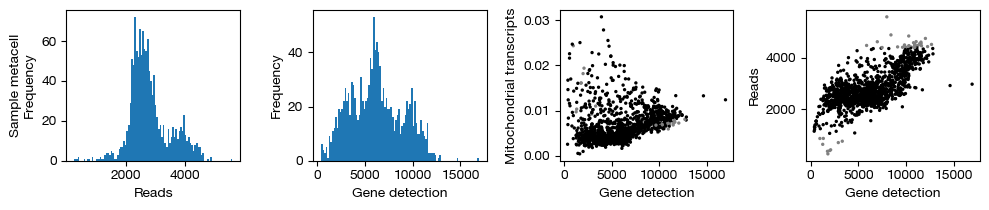

In [32]:
figs = expm.plot_rna_qc(run_on_samples = ['metacell'])

In [21]:
expm.run_rna_scale_pca(
    run_on_samples = ['metacell'],
    hvg = 'vst.hvg',
    key_lognorm = 'X',
    key_scaled = 'scaled',
    key_added = 'pca', n_comps = 35,
    keep_sparse = False,
    random_state = 42,
    svd_solver = 'arpack'
)

In [23]:
expm.run_rna_knn(
    run_on_samples = ['metacell'],
    use_rep = 'pca',
    n_comps = None,
    n_neighbors = 30,
    knn = True,
    method = "umap",
    transformer = None,
    metric = "euclidean",
    metric_kwds = {},
    random_state = 42,
    key_added = 'neighbors'
)

In [24]:
expm.run_rna_umap(
    run_on_samples = ['metacell'],
    min_dist = 0.5,
    spread = 1,
    n_components = 2,
    maxiter = None,
    alpha = 1,
    gamma = 1,
    negative_sample_rate = 5,
    init_pos = "spectral",
    random_state = 42,
    a = None, b = None,
    key_added = 'umap',
    neighbors_key = "neighbors"
)

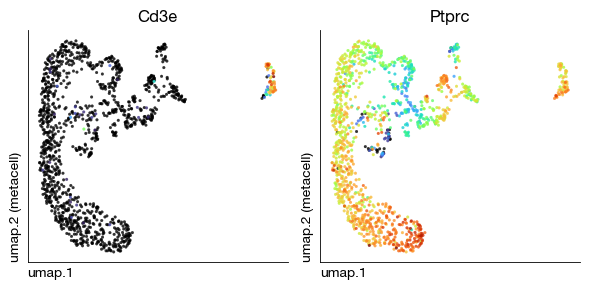

In [28]:
fig = expm.plot_rna_embedding_multiple(
    run_on_samples = ['metacell'], ncols = 2,
    basis = 'umap', features = ['Cd3e', 'Ptprc'], annotate_style = 'text', legend = False,
    figsize = (6, 3), dpi = 100, ptsize = 4, contour_plot = False
)

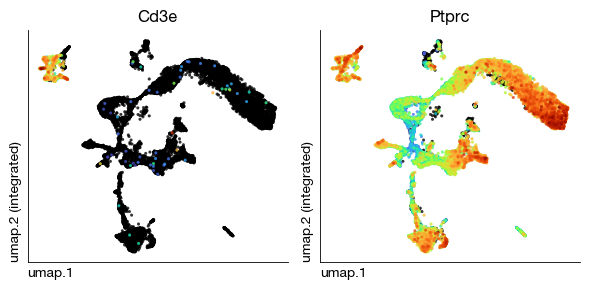

In [29]:
fig = expm.plot_rna_embedding_multiple(
    run_on_samples = False, ncols = 2,
    basis = 'umap', features = ['Cd3e', 'Ptprc'], annotate_style = 'text', legend = False,
    figsize = (6, 3), dpi = 100, ptsize = 4, contour_plot = False
)

In [34]:
expm.save()

[i] main dataset write to expm/integrated.h5mu
[i] saving individual samples. (pass `save_samples = False` to skip)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━ modality [rna]           1 / 1     (00:00 < 00:00)
